In [23]:
import json
import re

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [24]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
def create_text_processor(word_index, max_length):
    filters = r'[!"#$%&()*+,\-./:;<=>?@\[\\\]^_`{|}~\t\n]'
    def text_to_sequence(text):
        cleaned = re.sub(filters, ' ', text.lower())
        tokens = [w for w in cleaned.split() if w]
        seq = [word_index.get(w, 0) for w in tokens]
        seq = [i for i in seq if i != 0][:max_length]
        return seq
    return text_to_sequence

def pad_sequence(seq, max_length):
    padded = np.zeros(max_length, dtype=np.int32)
    length = min(len(seq), max_length)
    padded[:length] = seq[:length]
    return padded

In [26]:
def load_samples(data_path):
    samples = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            samples.append(json.loads(line))
    return samples


def data_generator(samples, labels, text_to_sequence, max_length):
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    num_classes = len(labels)
    for sample in samples:
        seq = text_to_sequence(sample.get('sentence', ''))
        xs = pad_sequence(seq, max_length)
        lbl = sample.get('label')
        if lbl not in label_to_index:
            continue
        y = np.zeros(num_classes, dtype=np.float32)
        y[label_to_index[lbl]] = 1.0
        yield xs, y

In [ ]:
def create_model(num_classes, vocab_size, max_length, embedding_dim, lstm_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size,
                                  output_dim=embedding_dim),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(units=lstm_units, unroll=True, recurrent_activation='sigmoid', implementation=1)),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=num_classes,
                              activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [28]:
MAX_SEQ_LEN = 200
EMBEDDING_DIM = 100
LSTM_UNITS = 64
BATCH_SIZE = 16

In [29]:
data_path = '../data/text_pairs_dataset.jsonl'
vocab_path = '../data/vocab.json'

print('TensorFlow version:', tf.__version__)

with open(vocab_path, 'r', encoding='utf-8') as f:
    tokenizer = json.load(f)
word_index = tokenizer.get('word_index', {})
vocab_size = len(word_index) + 1

labels = ['company overview', 'company services',
            'client review', 'other', 'contact info']

TensorFlow version: 2.19.0


In [30]:
samples = load_samples(data_path)
size = len(samples)
print(f'Loaded {size} samples.')

Loaded 5725 samples.


In [31]:
text_to_sequence = create_text_processor(word_index, MAX_SEQ_LEN)
ds = tf.data.Dataset.from_generator(
    lambda: data_generator(samples, labels, text_to_sequence, MAX_SEQ_LEN),
    output_signature=(
        tf.TensorSpec(shape=(MAX_SEQ_LEN,), dtype=tf.int32),
        tf.TensorSpec(shape=(len(labels),), dtype=tf.float32),
    )
)
ds = ds.shuffle(buffer_size=size)

train_size = int(size * 0.8)
val_size = int(size - train_size)
train_ds = ds.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [32]:
model = create_model(len(labels), vocab_size,
                        MAX_SEQ_LEN, EMBEDDING_DIM, LSTM_UNITS)

In [41]:
history = model.fit(train_ds,
            validation_data=val_ds,
            epochs=5)

Epoch 1/5
    286/Unknown 5s 15ms/step - accuracy: 0.8444 - loss: 0.4858

2025-04-19 20:28:52.573972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16787509085294116781
2025-04-19 20:28:52.573993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11255521415302185434


287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8444 - loss: 0.4858 - val_accuracy: 0.8712 - val_loss: 0.4214
Epoch 2/5


2025-04-19 20:28:53.660310: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-19 20:28:53.660329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16787509085294116781
2025-04-19 20:28:53.660338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11255521415302185434


287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8625 - loss: 0.4432 - val_accuracy: 0.9045 - val_loss: 0.3503
Epoch 3/5


2025-04-19 20:28:59.925326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16787509085294116781
2025-04-19 20:28:59.925345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11255521415302185434


287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8737 - loss: 0.4132 - val_accuracy: 0.8975 - val_loss: 0.3590
Epoch 4/5


2025-04-19 20:29:06.173146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16787509085294116781
2025-04-19 20:29:06.173165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11255521415302185434


285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8919 - loss: 0.3565

2025-04-19 20:29:11.318113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11255521415302185434


287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8918 - loss: 0.3566 - val_accuracy: 0.9194 - val_loss: 0.2913
Epoch 5/5


2025-04-19 20:29:12.403934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16787509085294116781
2025-04-19 20:29:12.403954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11255521415302185434


287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9002 - loss: 0.3418

2025-04-19 20:29:17.521941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11255521415302185434


287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9002 - loss: 0.3418 - val_accuracy: 0.9053 - val_loss: 0.2928


2025-04-19 20:29:18.613821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16787509085294116781
2025-04-19 20:29:18.613844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11255521415302185434


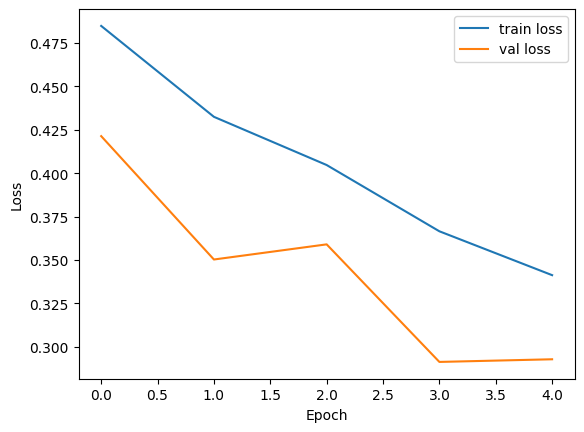

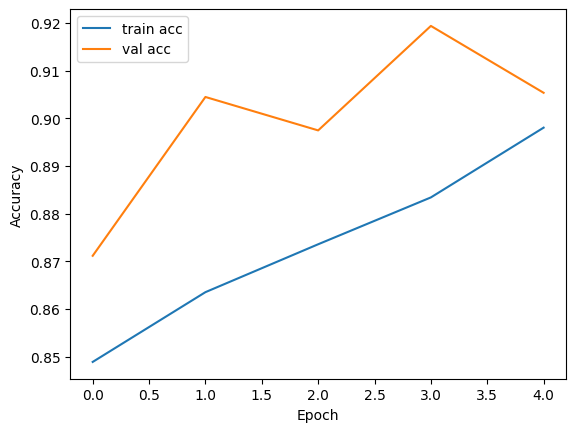

In [43]:
# Plot training & validation loss
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [44]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 100)       │     1,105,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,571,577 (13.62 MB)

 Trainable params: 1,190,525 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,381,052 (9.08 MB)

In [49]:
seq = text_to_sequence("Here at Built by Pros Inc. we have been a family run business since 1995. Our founder was born and raised in Toronto, Ontario, and we specialize in anything drywall related.")
xseq = pad_sequence(seq, MAX_SEQ_LEN)
print(xseq.shape)

(200,)


In [50]:
print(np.array([xseq]))
model.predict(np.array([xseq]))
# ['company overview', 'company services', 'client review', 'other', 'contact info']

[[ 343   50  265   48 1407  211    6   45  135    4  138  918   96  262
  2684    9 1610   87    1 4399    7   54  145    1    6  422    7 2224
   364 1518    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

array([[9.7722650e-01, 1.9758783e-02, 6.9965550e-04, 2.0962209e-03,
        2.1873692e-04]], dtype=float32)

In [52]:
model.save("../models/textzap.keras")

In [ ]:
# tf.saved_model.save(model, "../models/textzap")

INFO:tensorflow:Assets written to: ../models/textzap/assets


INFO:tensorflow:Assets written to: ../models/textzap/assets
